In [39]:
import codecs, json, glob, os, sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import tensorflow as tf
from sklearn.metrics import confusion_matrix, jaccard_score, classification_report, f1_score
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from generator import label_mapping
from utils.image_processing import read_resize

from utils.plotting import plot_image_label_prediction, plot_uncertainty_heatmaps, \
    plot_uncertainty_statistics, plot_image, plot_label, plot_predictions

result_json_dir = "/home/olle/PycharmProjects/LODE/workspace/feature_segmentation/opt_ensemble2"

configured_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 14, 15]

label_names = ["epiretinal membrane", "neurosensory retina", "intraretinal fluid", 
               "subretinal fluid", "subretinal hyper reflective material", 
               "RPE", "fibrovascular PED",
               "drusenoid PED", "posterior hyaloid membrane",
               "choroid", "fibrosis"]

## load json files to evaluate

In [20]:
def read_decode_json(file_path):
    obj_text = codecs.open(file_path, 'r', encoding='utf-8').read()
    
    json_result_file = json.loads(obj_text)

    json_result_file["image"] = np.array(json_result_file["image"])
    json_result_file["label"] = np.array(json_result_file["label"])
    json_result_file["prediction"] = np.array(json_result_file["prediction"])
    return json_result_file
    
json_result_paths = glob.glob(result_json_dir + "/*.json")

result_jsons = {}
for json_file_path in json_result_paths:
    record = json_file_path.split("/")[-1].replace(".json", "")
    result_jsons[record] = read_decode_json(json_file_path)

## plot records for publication

In [21]:
records = result_jsons.keys()

for record in records:
    record_log = result_jsons[record]
    data = [record_log["image"], record_log["label"], record_log["prediction"]]
    
    # all plotting functions
    plot_image_label_prediction(data,model_dir = result_json_dir, filename=record, mode="test")
    plot_image(record_log["image"], model_dir = result_json_dir, filename=record, mode="test")
    plot_label(record_log["label"], model_dir = result_json_dir, filename=record, mode="test")
    plot_predictions([record_log["prediction"]], model_dir = result_json_dir, filename=record, mode="test")

## create results per record result logs

In [22]:
records = result_jsons.keys()

f1_record_log = {}
f1_total_log = {}

all_labels = []
all_predictions = []

for record in records:
    record_log = result_jsons[record]
    
    labels = record_log["label"].flatten()
    predictions = record_log["prediction"].flatten()
    
    all_labels.extend(labels.tolist())
    all_predictions.extend(predictions.tolist())
    
    f1_record_log[record] = f1_score(labels, 
                         predictions, 
                         average = None, 
                         labels = configured_labels, 
                         zero_division=1)

# calculate for each log
f1_total_log = f1_score(all_labels, 
                        all_predictions, 
                        average = None, 
                        labels = configured_labels, 
                        zero_division=1)

# convert to data frames for plotting
total_f1_pd = pd.DataFrame(f1_total_log).T.replace(1.0,np.NaN)
record_f1_pd = pd.DataFrame(f1_record_log).T.replace(1.0,np.NaN)

,1,2,3,4,5,6,7,8,9,10,11
0,0.583168,0.980108,0.766243,0.97691,0.538299,0.837713,0.779026,0.634337,0.758062,0.882151,0.878357


Text(0, 0.5, 'f1-score')

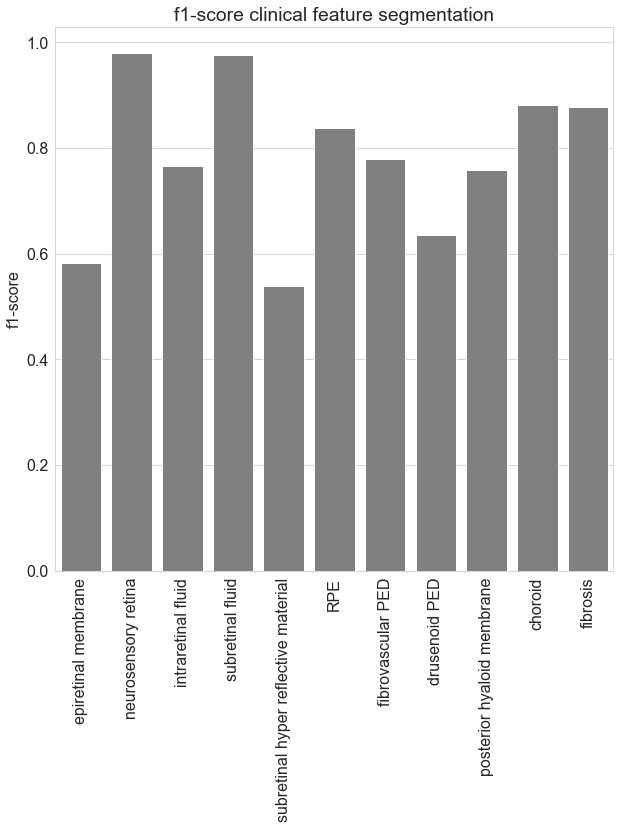

In [50]:
plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams.update({'font.size': 16})

sns.set_style("whitegrid")
ax = sns.barplot(data=total_f1_pd[np.arange(1,12)], color="grey")
plt.xticks(ticks=np.arange(0,11), labels=label_names, rotation=90)
plt.title("f1-score clinical feature segmentation")
plt.ylabel("f1-score")

## Inter doctor variation analysis

In [8]:
# set env variables
idv_json_dir = "/home/olle/PycharmProjects/LODE/workspace/feature_segmentation/opt_ensemble2/idv"
evaluators = ["ben", "johannes", "michael", "concensus"]

In [9]:
def read_decode_json(file_path):
    obj_text = codecs.open(file_path, 'r', encoding='utf-8').read()
    
    json_result_file = json.loads(obj_text)
    json_result_file["image"] = np.array(json_result_file["image"])
    
    # add all evaluators results
    for evaluator in evaluators:
        json_result_file[f"{evaluator}_mask"] = np.array(json_result_file[f"{evaluator}_mask"])

    json_result_file["prediction"] = np.array(json_result_file["prediction"])
    return json_result_file
    
json_result_paths = glob.glob(idv_json_dir + "/*.json")

result_jsons = {}
for json_file_path in json_result_paths:
    record = json_file_path.split("/")[-1].replace(".json", "")
    result_jsons[record] = read_decode_json(json_file_path)

## plot all records

In [10]:
records = result_jsons.keys()

for record in records:
    record_log = result_jsons[record]
    data = [record_log["image"], record_log["concensus_mask"], record_log["prediction"]]
    
    # all plotting functions
    plot_image_label_prediction(data,model_dir = idv_json_dir, filename=record, mode="test")
    plot_image(record_log["image"], model_dir = idv_json_dir, filename=record, mode="test")
    
     # add all evaluators results
    for evaluator in evaluators:
        plot_label(record_log[f"{evaluator}_mask"], 
                   model_dir = idv_json_dir, 
                   filename=f"{evaluator}_{record}", 
                   mode="test")

    plot_predictions([record_log["prediction"]], model_dir = idv_json_dir, filename=record, mode="test")

## extract results

In [11]:
records = result_jsons.keys()

f1_record_log = {}
f1_total_log = {}

labels_predictions = {"concensus": []}

for evaluator in evaluators + ["prediction"]:
    labels_predictions[evaluator] = []
        
for record in records:
    record_log = result_jsons[record]
    
    labels_predictions["prediction"].extend(record_log[f"prediction"].flatten().tolist())

    for evaluator in evaluators:
        labels_predictions[evaluator].extend(record_log[f"{evaluator}_mask"].flatten().tolist())


In [12]:
idv_logs = {}
for evaluator in evaluators + ["prediction"]:
    # calculate for each log
    f1_total_log = f1_score(labels_predictions["concensus"], 
                            labels_predictions[evaluator], 
                            average = None, 
                            labels = configured_labels, 
                            zero_division=1)

    idv_logs[evaluator] = f1_total_log
    
# convert to data frames for plotting
total_f1_pd = pd.DataFrame(idv_logs).T.replace(1.0,np.NaN)


In [13]:
pd.DataFrame(idv_logs)

,ben,johannes,michael,concensus,prediction
0,0.988385,0.982680,0.981553,1.0,0.978150
1,0.746925,0.650938,0.740741,1.0,0.504282
2,0.982336,0.984575,0.978435,1.0,0.967137
3,0.867624,0.651668,0.737249,1.0,0.483810
4,0.901279,0.979641,0.904317,1.0,0.832975
5,0.833611,0.777933,0.794467,1.0,0.586306
6,0.846473,0.823262,0.812042,1.0,0.741323
7,0.753525,0.793027,0.715472,1.0,0.602103
8,0.800503,0.888522,0.301601,1.0,0.289868
9,0.841681,0.788520,0.760241,1.0,0.628173


In [14]:
total_f1_pd

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
ben,0.988385,0.746925,0.982336,0.867624,0.901279,0.833611,0.846473,0.753525,0.800503,0.841681,0.915878,0.413384,0.996973,0.999978
johannes,0.982680,0.650938,0.984575,0.651668,0.979641,0.777933,0.823262,0.793027,0.888522,0.788520,0.867883,0.659488,0.996652,0.999962
michael,0.981553,0.740741,0.978435,0.737249,0.904317,0.794467,0.812042,0.715472,0.301601,0.760241,0.870446,0.319196,0.995728,0.999958
concensus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
prediction,0.978150,0.504282,0.967137,0.483810,0.832975,0.586306,0.741323,0.602103,0.289868,0.628173,0.832984,0.726384,0.993543,0.991139
